# Evaluation of our final models

## Includes: 
- 4 Models: standard finetuning, only 3 Layers trained, only 6 Layers trained, Full model trained
- Grammar stats and Translation stats

1. Grammar stats of the untrained GPT2 model
    - we need to beat that atleast

2. Translation stats for the different translation models. 
    - 3 Translation datasets: Training data, testing data long, testing data short and testing data with no filters
    - The tree trained models are compared on a number of statistics based and on all 4 datasets
    - Grouped by models aswell as grouped by dataset (same values, but improves understanding) 
    
### Explanations: 
3. Grammar_stats:
    - Basically Error rates per Token, can be grouped in specific mistakes if needed
    
    
4. datasets:
    - Format: Sentence=Translation Sentence=Translation<|endoftext|>   
    - All datasets are split on EOS tokens. 
    - Sentences with no mistakes are excluded from the datasets (except the last) 
    - All datasets exclude sentences with over 100 mistakes ---> trash filter
    - Sentence pair --> Sentence=Translation
    - train: a sample of the training data (700 characters for one sentence pair max. This filter is active on the real training data aswell)
    - test_700: testing data with a max length of a 700 characters for one sentence pair
    - test_long: testing data with no max length
    - test_nf_lrong: testing data which includes correct sentences also and has no max length filter
    - test_nf_700: testing data which includes correct sentences also and with a max length of 700 characters per sentence pair
    

5. Translation stats:
    - Correct Trans: The generated text is equal to the correct translation
    - Trans included: The correct translation was included in the generated text (still additional words) 
    - Rep included: The generated text is included in the condition
    - Real in cond: The real translation is included in the condition 
    - Len Trans = Real: The length of the generated text is equal to the length of the correct translation
    - Length Trans: Length of the translation 
    - Length Real: Length of the correct translation
    - Average Levenstein Real/Trans: Average Levenshtein Distance between the generated text and the correct translation
    

### Observations:
- As soon as we include correct sentences the model does not perform. 
    - Going to doublecheck the dataset right now and investigate whats wrong
    - ! This is a big problem since the idea is to autocorrect the basic GPT. If we cant handle correct sentences this will not work!
- The number of layers is pretty much linear correlated with the performance of the model. 
    - While all models work, it seems like we need to full model after all for the maximum performance...
- Longer sentences are still working fine. 

In [1]:
# Set the GPU for training
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [1]:
import torch
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel, modeling_utils, GPT2Config, modeling_gpt2, GPT2Model, GPT2PreTrainedModel, GPT2Config
import copy
import operator
import json
import numpy as np
import pandas as pd
import language_check
from functools import reduce
import difflib
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

from utility import *

In [2]:
data = load_datasets()
trans = load_data()

In [3]:
calculate_model(trans,data)

# Vanilla GPT2 error rate

In [8]:
titles = ["Number of wrong sentences", "Number of Mistakes", "Number of tokens",
          "Errors per TOken","Error per sentence"]

In [9]:
%%capture
out,out2 = full_pipeline_base()

In [10]:
pd.DataFrame(out,index=titles)

,0
Number of wrong sentences,612.000000
Number of Mistakes,2125.000000
Number of tokens,33615.000000
Errors per TOken,0.063216
Error per sentence,2.125000


# Translation comparisons

## Model based:

In [4]:
l3 = reload("3")
l6 = reload("6")
lf = reload("full")

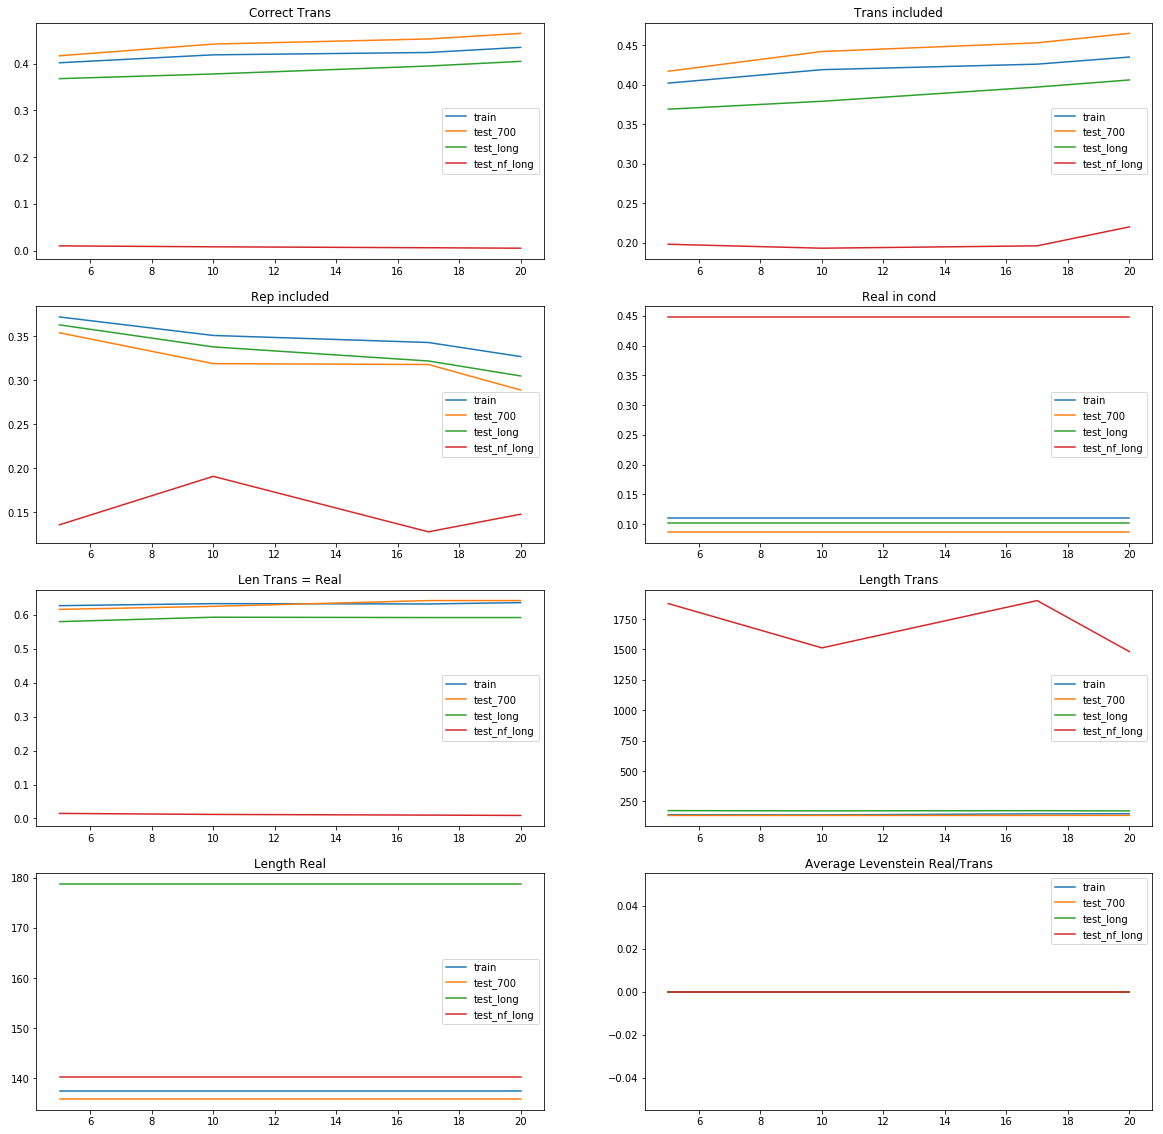

In [8]:
format_reloads_model(l3)   # 0,1,2,3----> 5,10,17,20

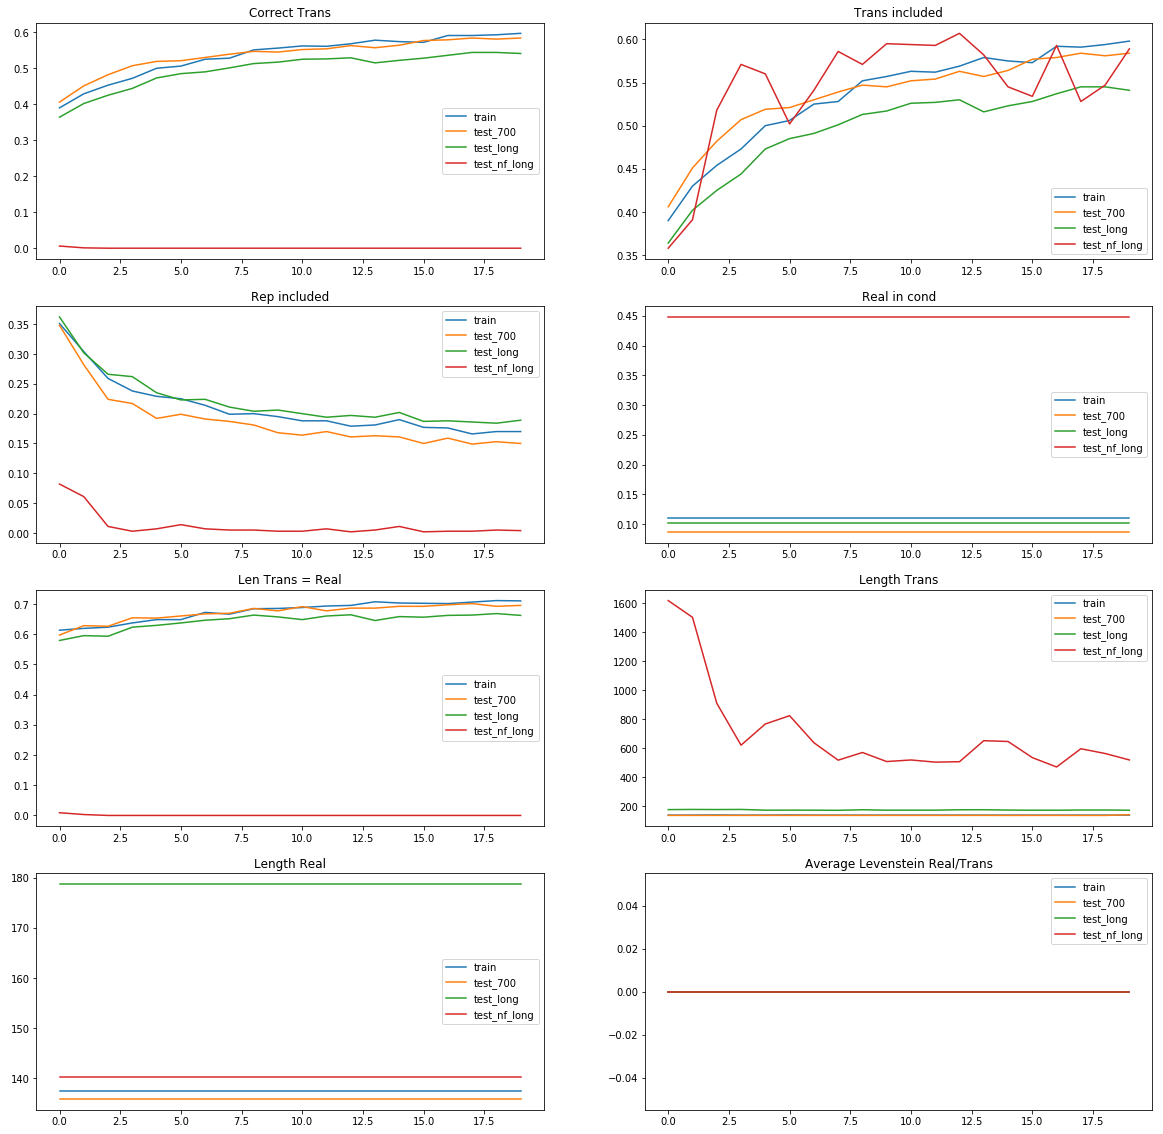

In [5]:
format_reloads_model(l6)

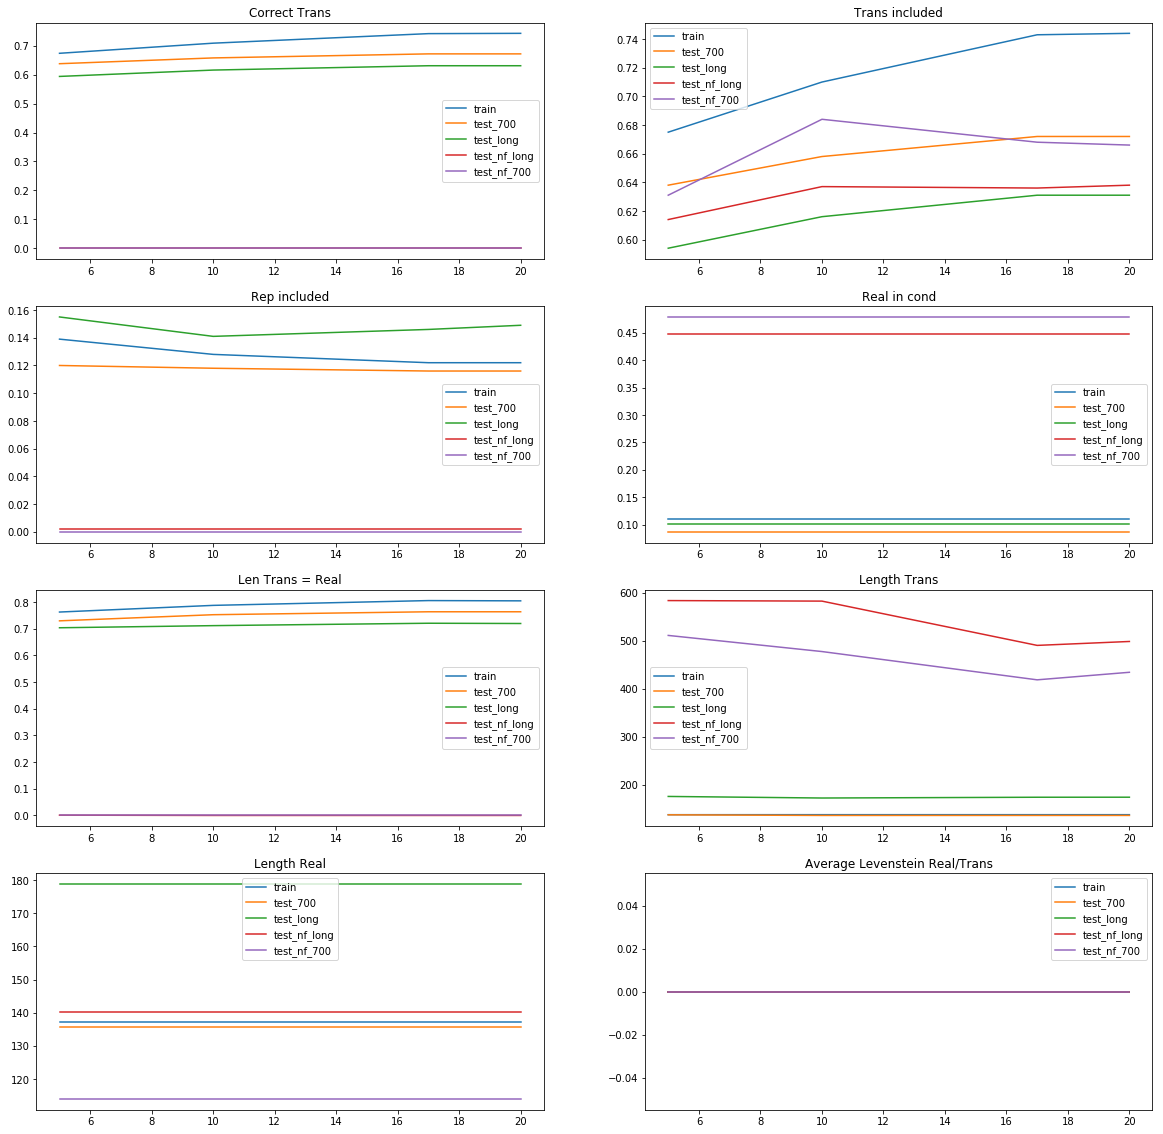

In [7]:
format_reloads_model(lf)

## Stat based

In [9]:
l3 = reload("3")
l6 = reload("6")
lf = reload("full")

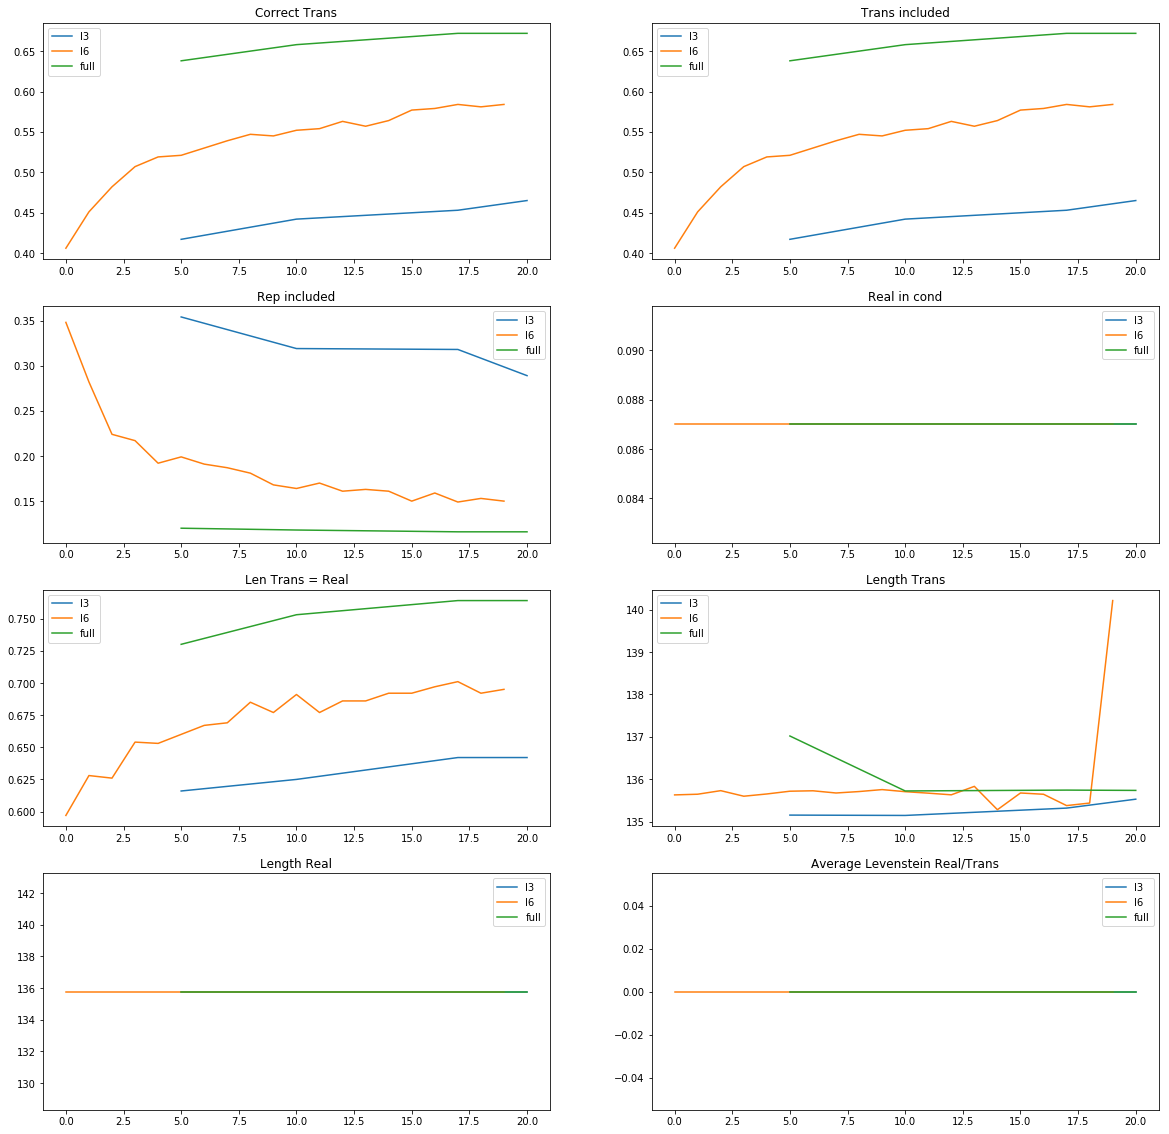

In [13]:
format_reloads_dataset(l3,l6,lf,"test_700")

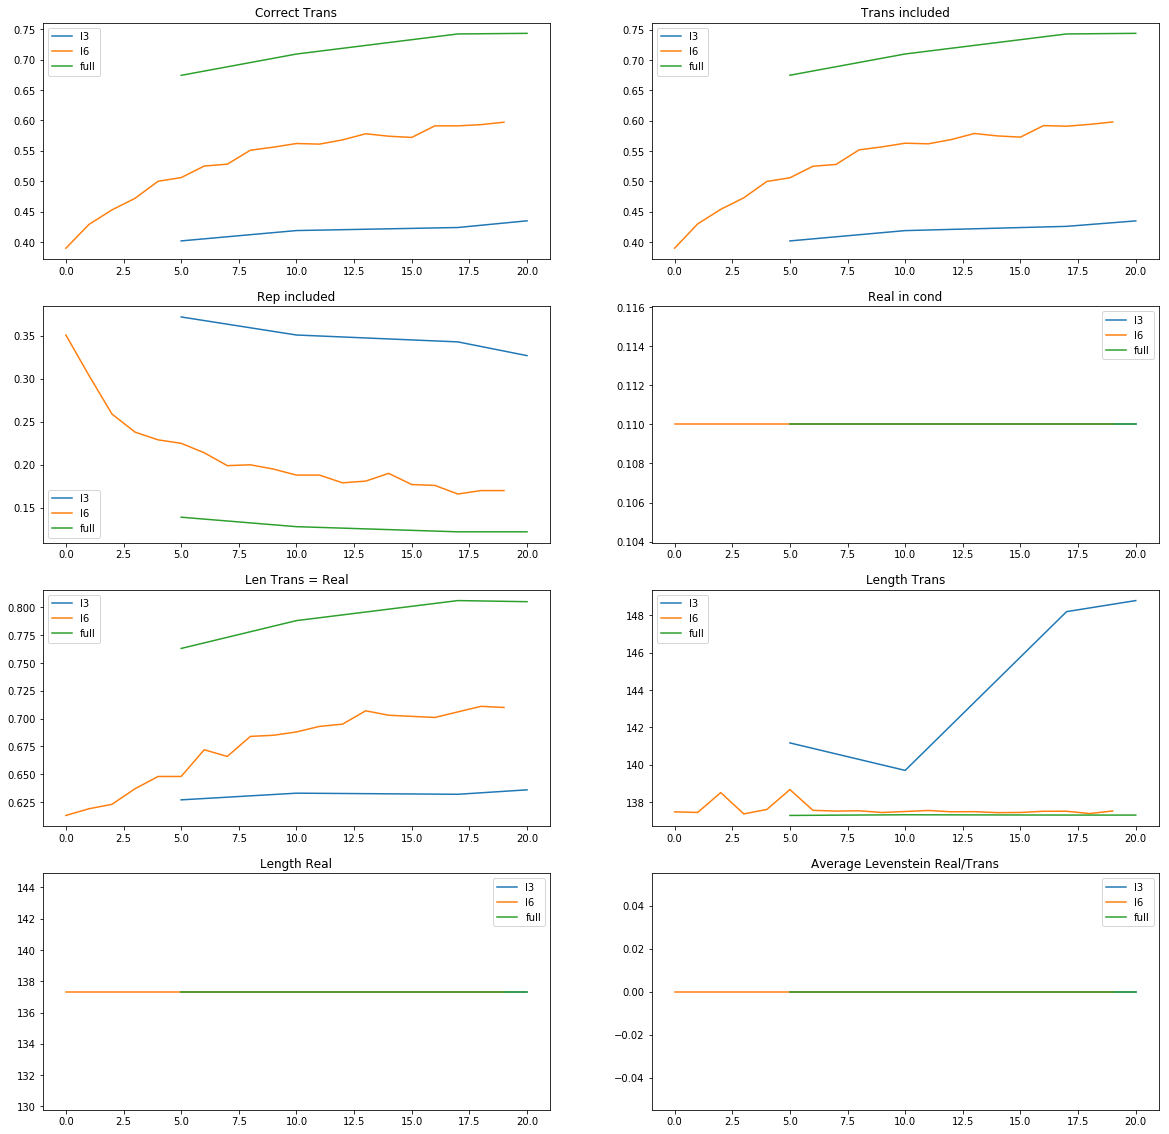

In [16]:
format_reloads_dataset(l3,l6,lf,"train")

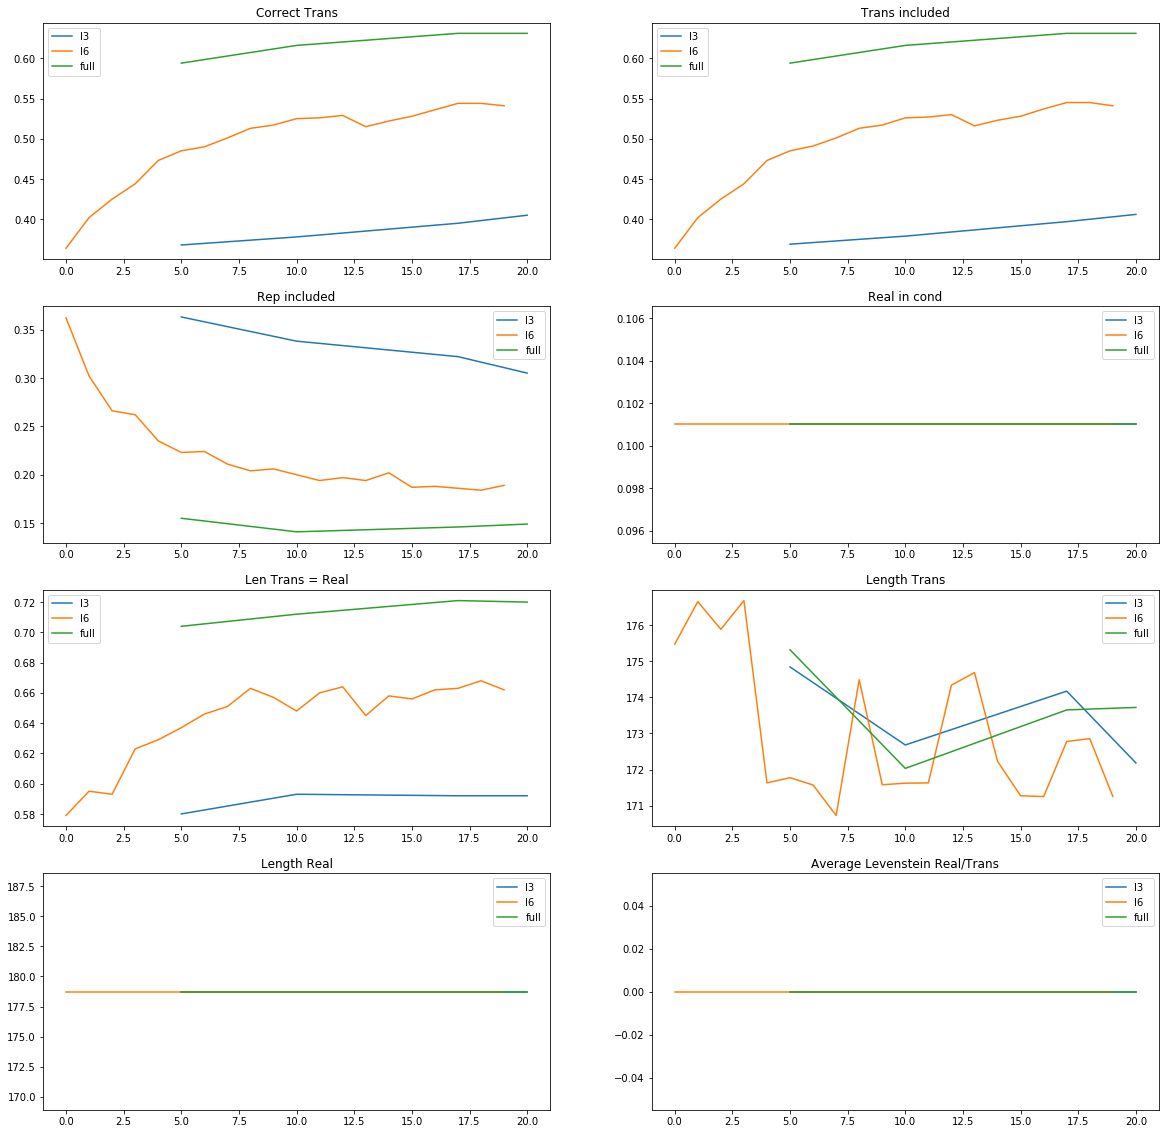

In [15]:
format_reloads_dataset(l3,l6,lf,"test_long")

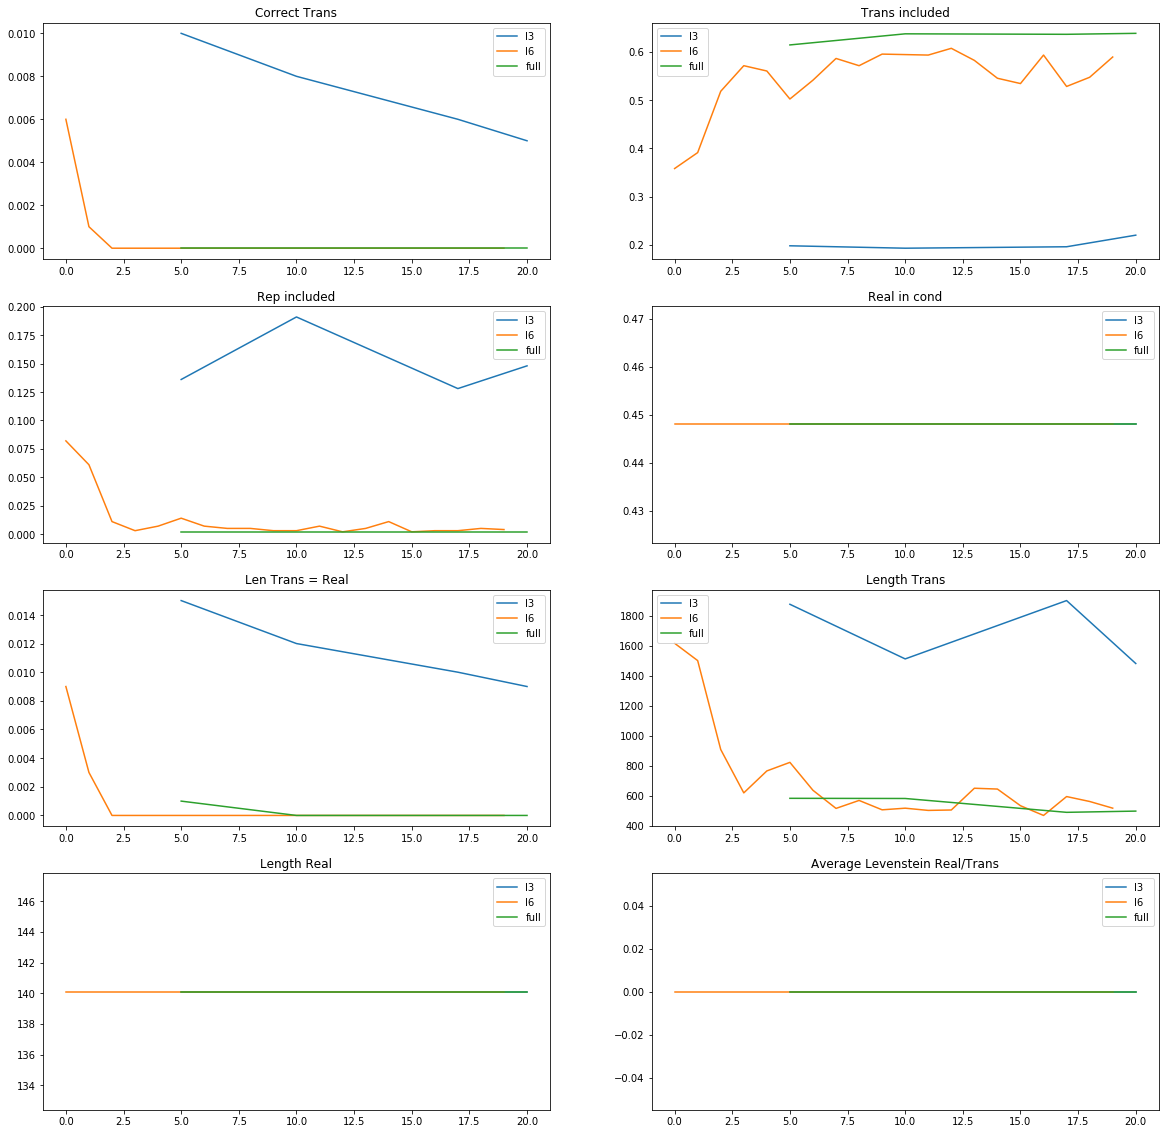

In [17]:
format_reloads_dataset(l3,l6,lf,"test_nf_long")

In [18]:
format_reloads_dataset(l3,l6,lf,"test_nf_700")

KeyError: 'test_nf_700'

<Figure size 1440x1440 with 0 Axes>

# Take a look at the 4th dataset

In [80]:
data = open("EOS_new_test_no_filter_700max.txt","r+")
data= data.read()
data = data.split("<|endoftext|>")
data = split_train_2(data)
trans = pickle.load(open("full/test_no_filter_700/the_dream_test_20_2_4.p","rb"))
trans2 = pickle.load(open("full/test_all_wrong_long/the_dream_test_20_long_4.p","rb"))
data2 = open("EOS_new_test.txt","r+")
data2= data2.read()
data2 = data2.split("<|endoftext|>")
data2 = split_train_2(data2)

In [81]:
def generation(model,tokenizer,condition):
    sentence = condition
    inp = torch.tensor(tokenizer.encode(condition)).unsqueeze(0)
    with torch.no_grad():
        for x in range(1024 - len(inp[0])): ## stop generation on the max length
            outputs = model(inp)
            predictions = outputs[0]
            new = torch.tensor([[torch.argmax(predictions[0, -1, :]).item()]])
            inp = torch.cat((inp,new),1)
            if new[0][0].item() == 50256: #EOS token
                break 
        predicted_text = tokenizer.decode(inp.tolist()[0][len(tokenizer.encode(condition)):])
    return predicted_text

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(torch.load("pytorch_model.bin"))
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [62]:
data[9]

' May 1st to end Page 200 Page 201 Page 222 Page 215 In 2013 shows are only 4 in total books on Virtual Ships in Fannie Courton, Part One: Vintage Furniture Production by Sir Richard Taylor "for the instruction of the Institute of Arts and the Deaf Plane , which produced Byunzick, O\'Brien, Dunlap and Fencing with Mr. ==== May 1st to end Page 200 Page 201 Page 222 Page 215 In 2013 shows are only 4 in total books on Virtual Ships in Fannie Court, Part One: Vintage Furniture Production by Sir Richard Taylor “for the instruction of the Institute of Arts and the Deaf Plane, which produced Byunzick, O\'Brien, Dunlap and Fencing with Mr. Tingle before and postexpulsion. ==== Tingle before and post expulsion.'

In [63]:
data2[5]

' May 1st to end Page 200 Page 201 Page 222 Page 215 In 2013 shows are only 4 in total books on Virtual Ships in Fannie Courton, Part One: Vintage Furniture Production by Sir Richard Taylor "for the instruction of the Institute of Arts and the Deaf Plane , which produced Byunzick, O\'Brien, Dunlap and Fencing with Mr.==== May 1st to end Page 200 Page 201 Page 222 Page 215 In 2013 shows are only 4 in total books on Virtual Ships in Fannie Court, Part One: Vintage Furniture Production by Sir Richard Taylor “for the instruction of the Institute of Arts and the Deaf Plane, which produced Byunzick, O\'Brien, Dunlap and Fencing with Mr. Tingle before and postexpulsion.==== Tingle before and post expulsion.'

In [86]:
test1 = tokenizer.tokenize(data2[0][5])

In [87]:
test2 = tokenizer.tokenize(data[0][9])

# --> Found the mistake! Wrong tokenization because of one extra backspace....